In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import cv2

import torch
from torch.utils.data import Dataset
from torchvision import transforms as T
from utils.helpers import generate_list_of_images

from utils import palette

### Define Massuchusetts Roads Dataset

In [9]:
import albumentations as A

def augmentations(image_size = 512):
    return A.Compose([
        A.RandomCrop(width = image_size, height = image_size, p=1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.25),
        A.Blur(p=0.01, blur_limit = 3),
    ], p = 1)

In [4]:
class MassuchusettsDataset(Dataset):
    

    def __init__(self,file_path, transforms = None, preprocessing = True):
        
        self.file_path = file_path
        self.transforms = transforms
        self.num_classes = 2
        self.preprocessing = preprocessing
        self.palette = palette.get_voc_palette(self.num_classes)
        self.MEAN = [0.4284687070054998, 0.4314829391019595, 0.39509143287278337]
        self.STD = [0.2920699753022457, 0.285627042080093, 0.2974879931626558]
        self.imgs, self.labels = self._prepare_data()
        
    def _prepare_data(self):
        return generate_list_of_images(self.file_path)
    
    def apply_normalization(self, img):
        
        transform = T.Compose([
                        T.ToTensor(),
                        T.Normalize(
                            mean=self.MEAN,
                            std=self.STD)
                    ])
        
        return transform(img)
    
    def __len__(self):
        assert len(self.imgs) == len(self.labels)
        return len(self.imgs)
        
    def __getitem__(self, index):
        
        img = cv2.imread(self.imgs[index])
        img = cv2.cvtColor(img, cv2. COLOR_BGR2RGB)
        mask = cv2.imread(self.labels[index], -1)/255
        
        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        
        if self.preprocessing:
            img = self.apply_normalization(img)
        
        return img, torch.Tensor(mask).long()

### Load the Dataset

In [6]:
import os
root_dir = "/scratch/saksham/data/road_segmentation_ideal/"

train_file = os.path.join(root_dir, "train.csv")
val_file = os.path.join(root_dir, "val.csv")

In [10]:
transforms = augmentations(512)

train_dataset = MassuchusettsDataset(file_path = train_file, transforms = transforms)
val_dataset = MassuchusettsDataset(file_path = val_file, transforms = None)

### Percentage of Pixels with Roads

In [8]:
from tqdm import tqdm

summ = 0
for ind in tqdm(range(len(train_dataset))):
    perc_pixels = (train_dataset[ind][1].sum()/(train_dataset[ind][1].shape[0]*train_dataset[ind][1].shape[1])).item()
    summ += perc_pixels
    avg = summ/(ind+1)

print(avg)

100%|██████████| 643/643 [04:12<00:00,  2.54it/s]

0.05210290911779804


In [18]:
from tqdm import tqdm

summ = 0
for ind in tqdm(range(len(val_dataset))):
    perc_pixels = (val_dataset[ind][1].sum()/(val_dataset[ind][1].shape[0]*val_dataset[ind][1].shape[1])).item()
    summ += perc_pixels
    avg = summ/(ind+1)

print(avg)

100%|██████████| 161/161 [01:06<00:00,  2.44it/s]

0.053452140859889315


### Visualise your Dataloader

In [13]:
import matplotlib.pyplot as plt
import random

def visualize(image, mask):
    fontsize = 18

    f, ax = plt.subplots(1, 2, figsize=(8, 8))

    ax[0].imshow(image)
    ax[1].imshow(mask)

In [16]:
random_idx = random.randint(0, len(train_dataset)-1)
img, mask = train_dataset[random_idx]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


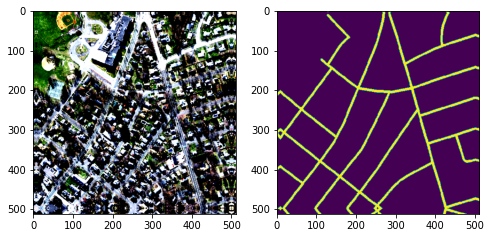

In [17]:
visualize(img.permute(1,2,0), mask)